<a href="https://colab.research.google.com/github/SamuelMiller413/Coding-Nomads-Deep-Learning-Miniproject-1/blob/master/DL_Miniproject_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Intrdouction
---

## Problem Statement:
> An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market.

>In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

>You are required to help the manager to predict the right group of the new customers.

## Resources
>Data    (from Kaggle)
* [Customer Segmentation Dataset](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation?select=train.csv) 

> Notebooks of Influence
* [Janatahack](https://www.kaggle.com/code/abisheksudarshan/av-janatahack-customer-segmentation/data) 
* [Seun Ayegboyin](https://www.kaggle.com/code/seunayegboyin/customer-segmentation-with-kmeans-and-pca) (PCA/Clustering)

---
# Work Flow
---

### NOTES
* Write 
        def grep()
        def greps_all()
* OHE all
* Impute NaN
* Train Models
* Train DL Models


### Workflow Outline

---
#### 1. Pre-Training
---
* Setup
    * Data Loading
    * Download the Dataset
    * Split Data
    * Custom Functions
* Initial EDA / Data Visualization
* Feature Engineering and Transformation
* Continued EDA / Data Visualization
* Pipelines
<br>
---
#### 2. Training
---
* Traditional ML Modeling
* Pure Torch Model
* High-level Libraries and Tabular Frameworks
<br>
---
#### 3. Testing
---
* Model Selection and Test Set Evaluation
* Notes and Findings



---
# 1. Pre-Training
---
* Setup
    * Data Loading
    * Download the Dataset
    * Split Data
    * Custom Functions
* Initial EDA / Data Visualization
* Feature Engineering and Transformation
* Continued EDA / Data Visualization
* Pipelines

## Setup

#### Retrieval and Cloud Connection

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# upload 'kaggle.json'
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samuelmiller413","key":"d635e1518efc064bb478bb67bb2c22aa"}'}

In [3]:
# make kaggle directory 
! mkdir ~/.kaggle
# store JSON
! cp kaggle.json ~/.kaggle/
# change permissions
! chmod 600 ~/.kaggle/kaggle.json

# download data from kaggle
! kaggle datasets download -d 'abisheksudarshan/customer-segmentation'
# make directory for data
! mkdir customer-segmentation

# unzip into directory
! cd.. customer-segmentation/
! unzip customer-segmentation.zip -d customer-segmentation/
# remove .zip
! rm -r customer-segmentation.zip

  0% 0.00/98.7k [00:00<?, ?B/s]
100% 98.7k/98.7k [00:00<00:00, 60.3MB/s]
/bin/bash: cd..: command not found
Archive:  customer-segmentation.zip
  inflating: customer-segmentation/test.csv  
  inflating: customer-segmentation/train.csv  


#### Imports

In [4]:
%%capture
# import libraries
import numpy as np 
import pandas as pd
import torch 
import pprint
import inspect

# PRE-PROCESSING
import sklearn.preprocessing as preprocessing                                                                          
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import CategoricalImputer

#  MODELS
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier as lgbm

# FEATURE SELECTION                                                                          
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, RFE, RFECV

# PIPELINE                                     
from sklearn.pipeline import Pipeline
                                          
# NEURAL NETWORK                                                   
from sklearn.neural_network import MLPRegressor
from torch import nn
import torch.nn.functional as F
!pip install torchmetrics attrdict -q
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from attrdict import AttrDict
from multiprocessing import cpu_count

# CROSS VALIDATION
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve, cross_val_predict
from sklearn.model_selection import KFold, RandomizedSearchCV

# EVALUATION
from sklearn.metrics import mean_squared_log_error, mean_squared_error, roc_auc_score, accuracy_score, log_loss, classification_report
from sklearn.metrics import silhouette_score
from sklearn.metrics import SCORERS

# PLOTTING
import random
import matplotlib.pyplot as plt
import seaborn as sns

# FROM example janatahack notebook 

# IGNORE WARNINGS
import warnings
warnings.filterwarnings("ignore")
from collections import Counter


#### Download Dataset

In [5]:
csv_train = '/content/customer-segmentation/train.csv'
csv_test = '/content/customer-segmentation/test.csv'

#### Split Data

In [50]:
'''
    data is pre-split into train/test csv files: 
    1. train:   contains all columns
    2. test:    contains no label columnn

    > Treating 'train' as a full dataset

    Instead of an X, y split, 
        using: 
            X = feature_cols    
            y = label_col   
'''
# read csv
df = pd.read_csv(csv_train)

# train_test split 80/20
train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=42
    )

# reset indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# features
feature_cols = train_df.columns.tolist()
feature_cols.remove('Segmentation')

# label
label_col = 'Segmentation'

In [51]:
# train_df[feature_cols].isnull().sum()
# train_df[label_col].isnull().sum()
len(train_df[label_col])

6454

## Functions

### Retrieve Variable Name

In [8]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
    # above code --> https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
                            # user: scohe001

### Summarize

In [9]:
def summarize(subset=None):
    '''
    Doc:
    Summarizes EDA for Pandas dataframe.

        Parameters
        -------------
            subset      : (dataframe)
                Specify the dataframe or subset of dataframe to summarize
        Returns
        -------------
            Summary functions from those stored in eda_summary
    '''
    # initialize summary dict
    eda_summary_att = {
        'shape':subset.shape, 
        'isnull':subset.isnull,
        'dtypes':subset.dtypes
        }
    eda_summary_func = { 
        'info':subset.info,     
        'describe':subset.describe(),
        'corr':subset.corr(),
        'value_counts':subset.value_counts()
        }
    # display name of subset
    print(f"\nSummary of Subset:  '{retrieve_name(subset)[0]}'\n")
    # loop through and call each summary function
    for k,v in eda_summary_att.items():
        if k == 'isnull':
            v = eda_summary_att[k]().sum()
            print(f"\n--------\n{k.upper()}\n--------\n\n{v}\n---")    
        else:
            # summary = subset.v()
            print(f"\n--------\n{k.upper()}\n--------\n\n{v}\n---")
    for k,v in eda_summary_func.items():
        if k == 'value_counts':
            for i in range(1,(len(subset.columns)-1)):
                by_feature = subset[subset.columns[i]]
                print(by_feature.value_counts())

        else:
            print(f"\n--------\n{k.upper()}\n--------\n\n{v}\n---")

### Data Viz

In [10]:
# initialize plotting dict
graph_ = {
    'relplot': sns.relplot,
    'scatterplot': sns.scatterplot,
    'lineplot': sns.lineplot,
    'displot': sns.displot,
    'histplot': sns.histplot,
    'kdeplot': sns.kdeplot,
    'ecdfplot': sns.ecdfplot,
    'rugplot': sns.rugplot,
    'catplot': sns.catplot,
    'stripplot': sns.stripplot,
    'swarmplot': sns.swarmplot,
    'boxplot': sns.boxplot,
    'violinplot': sns.violinplot,
    'boxenplot': sns.boxenplot,
    'pointplot': sns.pointplot,
    'barplot': sns.barplot,
    'countplot': sns.countplot,
    'lmplot':' sns.lmplot',
    'regplot': 'sns.regplot',
    'residplot': 'sns.residplot',
    'heatmap': 'sns.heatmap',
    'clustermap': 'sns.clustermap',
    'FacetGrid': 'sns.FacetGrid',
    'pairplot': 'sns.pairplot',
    'PairGrid': 'sns.PairGrid',
    'jointplot': 'sns.jointplot',
    'JointGrid': sns.JointGrid
    }
# plot sizes    
sizes = {'s':((10,6)),'m':(14,8), 'l':(18,10)}

def plot_grep(feature, label=label_col, plot_type='countplot', fig_size='s',subset=train_df): 
    '''
    Doc:
    Greps feature with label.
    Displays a seaborn plot of grep.

        Parameters
        -------------
            feature   : (str)
                Feature to plot 'label' by
            label     : (str)    
                Label (or additional feature) to plot 'feature' by  
                default   = target
                    * save a variable 'target' as df.columns['target variable']               
            plot_type : (dict)
                Specify a seaborn plot function from {graph_}
                    default: 'countplot'      
            fig_size  : {'s', 'm', 'l'}
                Choose a small , medium, or large figure size
                default   : {'s'=10x6, 'm'=14x8, 'l'=18x10}
            subset    : (dataframe)
                Specify which subset of the dataframe to use
                default   = 'train_df'
                examples  : 'train_df', 'test_df', etc.
        
        Returns
        -------------
            Seaborn plot of grep(feature,label)

        Plot Options: 
        -------------
        --> from Seaborn API Reference : https://seaborn.pydata.org/api.html
        
        Relational Plots
        ---
        'relplot'     - Figure-level interface for drawing relational plots onto a FacetGrid.
        'scatterplot' - Draw a scatter plot with possibility of several semantic groupings.
        'lineplot'    - Draw a line plot with possibility of several semantic groupings.

        Distribution Plots
        ---
        'displot'     - Figure-level interface for drawing distribution plots onto a FacetGrid.
        'histplot'    - Plot univariate or bivariate histograms to show distributions of datasets.
        'kdeplot'     - Plot univariate or bivariate distributions using kernel density estimation.

        Categorical Plots
        ---
        'ecdfplot'    - Plot empirical cumulative distribution functions.
        'rugplot'     - Plot marginal distributions by drawing ticks along the x and y axes.
        'catplot'     - Figure-level interface for drawing categorical plots onto a FacetGrid.
        'stripplot'   - Draw a scatterplot where one variable is categorical.
        'swarmplot'   - Draw a categorical scatterplot with non-overlapping points.
        'boxplot'     - Draw a box plot to show distributions with respect to categories.
        'violinplot'  - Draw a combination of boxplot and kernel density estimate.
        'boxenplot'   - Draw an enhanced box plot for larger datasets
        'pointplot'   - Show point estimates and confidence intervals using scatter plot glyphs.
        'barplot'     - Show point estimates and confidence intervals as rectangular bars.
        'countplot'   - Show the counts of observations in each categorical bin using bars.

        Regression Plots
        ---
        'lmplot'      - Plot data and regression model fits across a FacetGrid.
        'regplot'     - Plot data and a linear regression model fit.
        'residplot'   - lot the residuals of a linear regression.

        Matrix Plots
        ---
        'heatmap'     - Plot rectangular data as a color-encoded matrix.
        'clustermap'  - Plot a matrix dataset as a hierarchically-clustered heatmap.

        MULTI-PLOT GRIDS

        FacetGrid
        ---
        'FacetGrid'   - Multi-plot grid for plotting conditional relationships.

        Pair Grids
        ---
        'pairplot'    - Plot pairwise relationships in a dataset.
        'PairGrid'    - Subplot grid for plotting pairwise relationships in a dataset.

        Joint 'Grids'
        ---
        'jointplot'   - Draw a plot of two variables with bivariate and univariate graphs.
        'JointGrid'   - Grid for drawing a bivariate plot with marginal univariate plots.
    '''
    # filter input for matching 
    feature = feature.title()
    label = label.title()
    # increase size for age
    if (feature == 'Age') & (fig_size == 's'):
        aging = True
        while aging == True:
            resp = input(f'This {feature} feature has quite the range!\n\
            Would you like to increase the size for better readability?\n\n(y) or (n)   --> ')
            if resp.lower() == 'n':
                print("You know best!")
                aging = False
            else:
                print("Great idea!")
                fig_size = 'm'
                aging = False   
    # plot
    fig, ax = plt.subplots(figsize=sizes[fig_size])
    graph_[plot_type](subset[feature],hue=subset[label])
    plt.show() 

def plot_all_grep(feature, plot_type='countplot', fig_size='s',subset=train_df): 
    '''
    **WRITE DOC**
    '''
    # filter input for matching 
    feature = feature.title()
    # label = label.title()target
    # increase size for age
    for i in range(1,(len(subset.columns)-1)):
        by_feature = subset[subset.columns[i]]
        if (subset.columns[i] == 'Age') & (fig_size == 's'):
            # plot
            fig, ax = plt.subplots(figsize=sizes['m'])
            graph_[plot_type](by_feature,hue=subset[feature])
            plt.show() 
        else:
            # plot
            fig, ax = plt.subplots(figsize=sizes[fig_size])
            graph_[plot_type](by_feature,hue=subset[feature])
            plt.show() 

### OHE

In [11]:
def ohe(subset=None):
    # must be run before fill_na
    obj_list = []
    for i in range(0,len(subset.dtypes)):
        if subset.dtypes[i] == 'object':
            if subset.columns[i] == 'Segmentation':
                pass
            else:
                obj_list.append(subset.columns[i])
        else:
            pass
    print(f"\nOHE of Subset:  '{retrieve_name(subset)[0]}'\n\nColumns Include:")
    [print(f"   {x}") for x in obj_list]
    resp = input("\nProceed with OHE?     y/n \n\n  -->  ")
    if resp == 'n':
        print("\nnevermind then...\n")
    else:
        print("\nLet's do it!\n")
        print(obj_list)
        subset = pd.get_dummies(data=subset, columns=obj_list)
        print("...")
        subset.head()
    return subset

### Encode Label

In [12]:
le = preprocessing.LabelEncoder()

### Impute

In [13]:
def fill_nan(subset=None):
    '''
    ** Write DOC ***
    '''
    imputer = CategoricalImputer()
    nan_list = []
    null_count = subset.isnull().any()
    for i in range(0,len(subset.columns)):
        if null_count[i] == True:
            nan_list.append(subset.columns[i])
        else:
            pass
    for feature in nan_list:
        # impute NaN values
        filled = imputer.fit_transform(np.array(subset[feature], dtype=float))
        # update subset
        subset[feature] = filled
    return subset

### Scale


In [14]:
scaler = StandardScaler()

### Transformation Script

In [15]:
def transform_df(subset=None):
    # ohe
    subset = ohe(subset)

    # impute
    subset_1 = fill_nan(subset)

    # feature cols
    feature_cols = subset.columns.tolist()
    feature_cols.remove('Segmentation')
    # label
    label_col = 'Segmentation'

    # scale
    scaled_array = scaler.fit_transform(subset_1[feature_cols])
    # return to df
    subset_1 = pd.DataFrame(scaled_array, columns=feature_cols)
    # Concat dfs
    subset = pd.concat([subset_1, subset[label_col]], axis=1)

    # encode label
    subset[label_col] =le.fit_transform(subset[label_col])
    
    return subset.astype(float)

### Cross Validate ###

In [16]:
cv = KFold(n_splits = 3, shuffle=True)

## Initial EDA & Data Visualization

In [17]:
summarize(train_df)


Summary of Subset:  'train_df'


--------
SHAPE
--------

(6454, 11)
---

--------
ISNULL
--------

ID                   0
Gender               0
Ever_Married       108
Age                  0
Graduated           58
Profession          91
Work_Experience    659
Spending_Score       0
Family_Size        260
Var_1               61
Segmentation         0
dtype: int64
---

--------
DTYPES
--------

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object
---

--------
INFO
--------

<bound method DataFrame.info of           ID  Gender Ever_Married  Age Graduated  Profession  Work_Experience  \
0     460591  Female          Yes   38       Yes      Doctor              1.0   
1     460459  Female           No   33        No    Engineer        

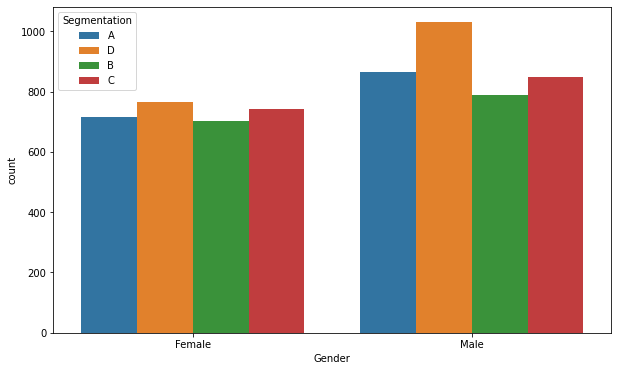

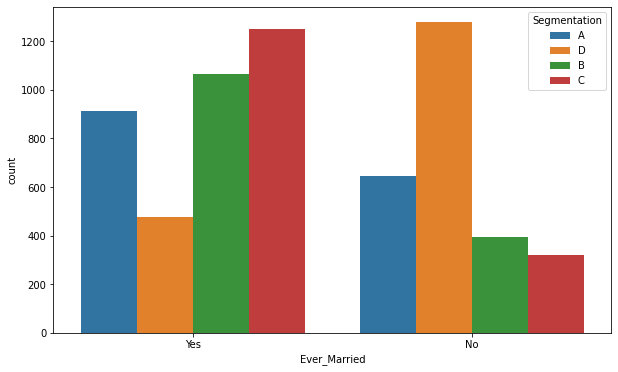

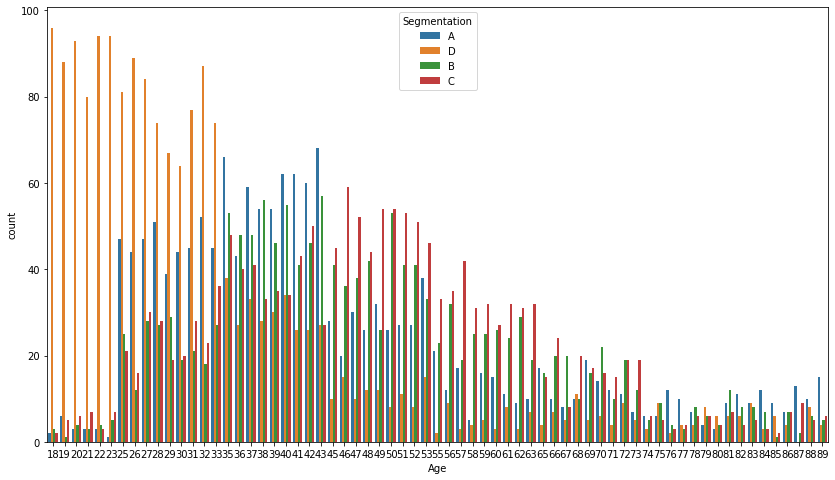

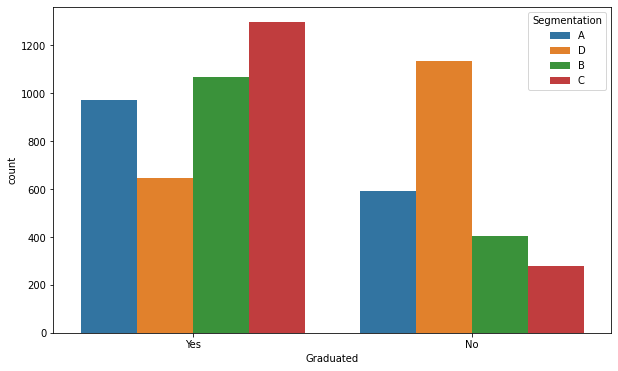

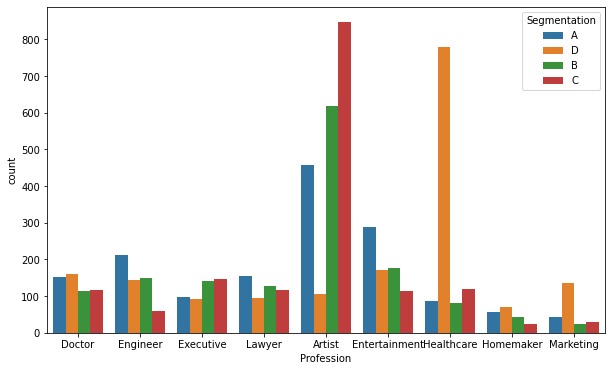

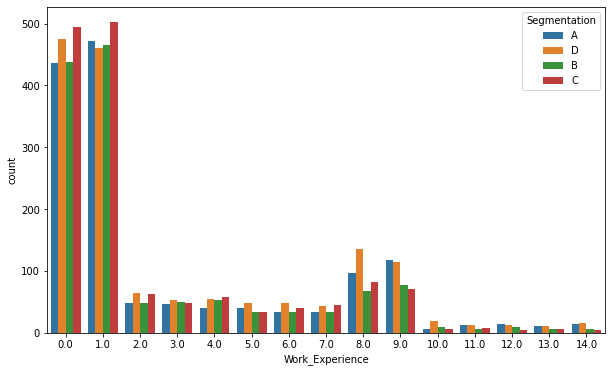

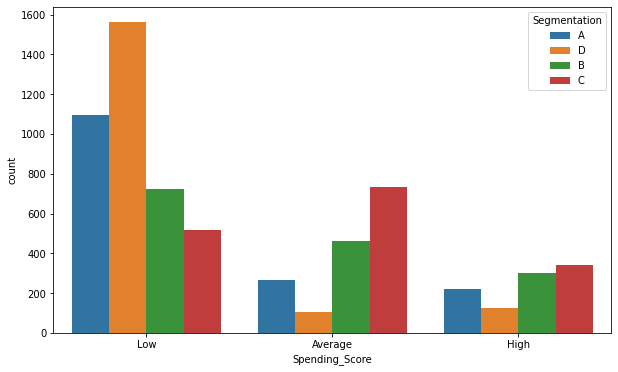

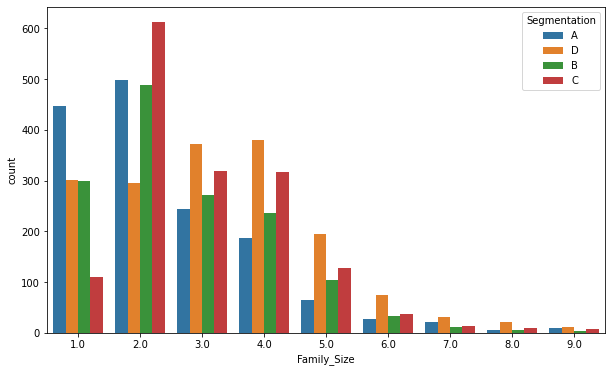

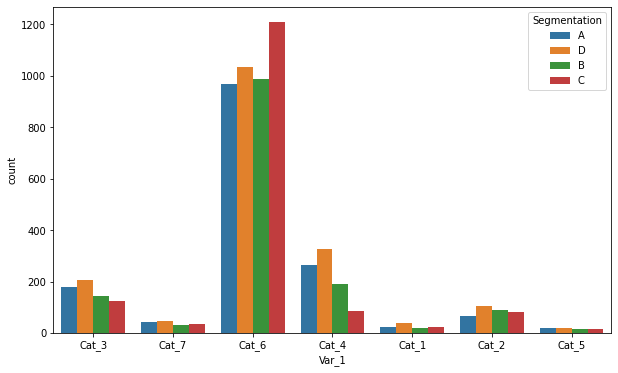

In [18]:
plot_all_grep('segmentation')

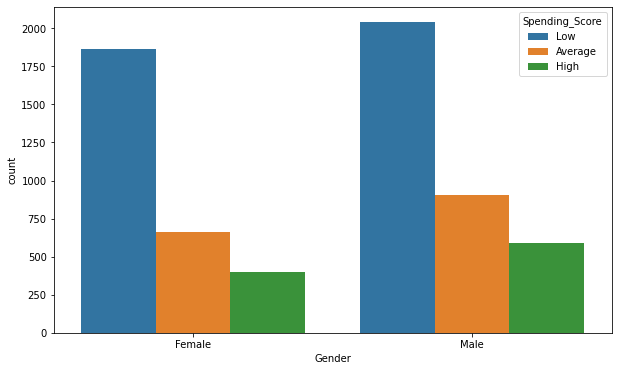

In [19]:
plot_grep(feature='Gender', label='spending_score')

In [20]:
train_df['Gender'].value_counts()

Male      3530
Female    2924
Name: Gender, dtype: int64

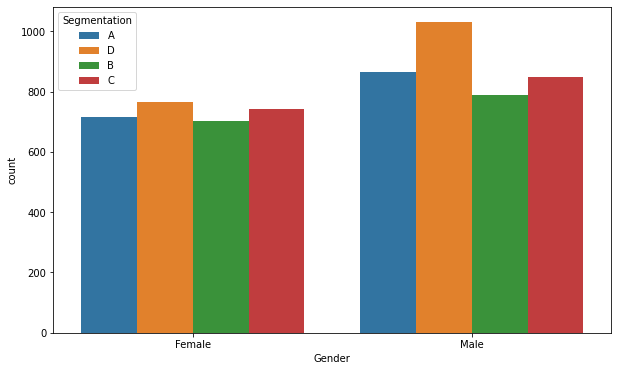

In [21]:
plot_grep('gender')

## Feature engineering and transformation

### Transform : Impute, OHE, Scale

In [22]:
# train_test split 80/20
train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=42
    )
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
# features
feature_cols = train_df.columns.tolist()
feature_cols.remove('Segmentation')

# label

In [23]:
# train
train_df = transform_df(train_df)
# test
test_df = transform_df(test_df)


OHE of Subset:  'subset'

Columns Include:
   Gender
   Ever_Married
   Graduated
   Profession
   Spending_Score
   Var_1

Proceed with OHE?     y/n 

  -->  y

Let's do it!

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
...

OHE of Subset:  'subset'

Columns Include:
   Gender
   Ever_Married
   Graduated
   Profession
   Spending_Score
   Var_1

Proceed with OHE?     y/n 

  -->  y

Let's do it!

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
...


In [24]:
# train_df.info()
# summarize(test_df)

#### Update Column Groups

In [25]:
# categorical
cat_cols = ['Gender_Female', 'Gender_Male', 'Ever_Married_No',
       'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Average', 'Spending_Score_High',
       'Spending_Score_Low', 'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3',
       'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7']

# continuous
cont_cols = ['Age','Work_Experience', 'Family_Size']

# features
feature_cols = train_df.columns.tolist()
feature_cols.remove('Segmentation')
# label
label_col = 'Segmentation'

# print(feature_cols)
# print('---')
# print(label_col)

## Continued EDA & Data Visualization

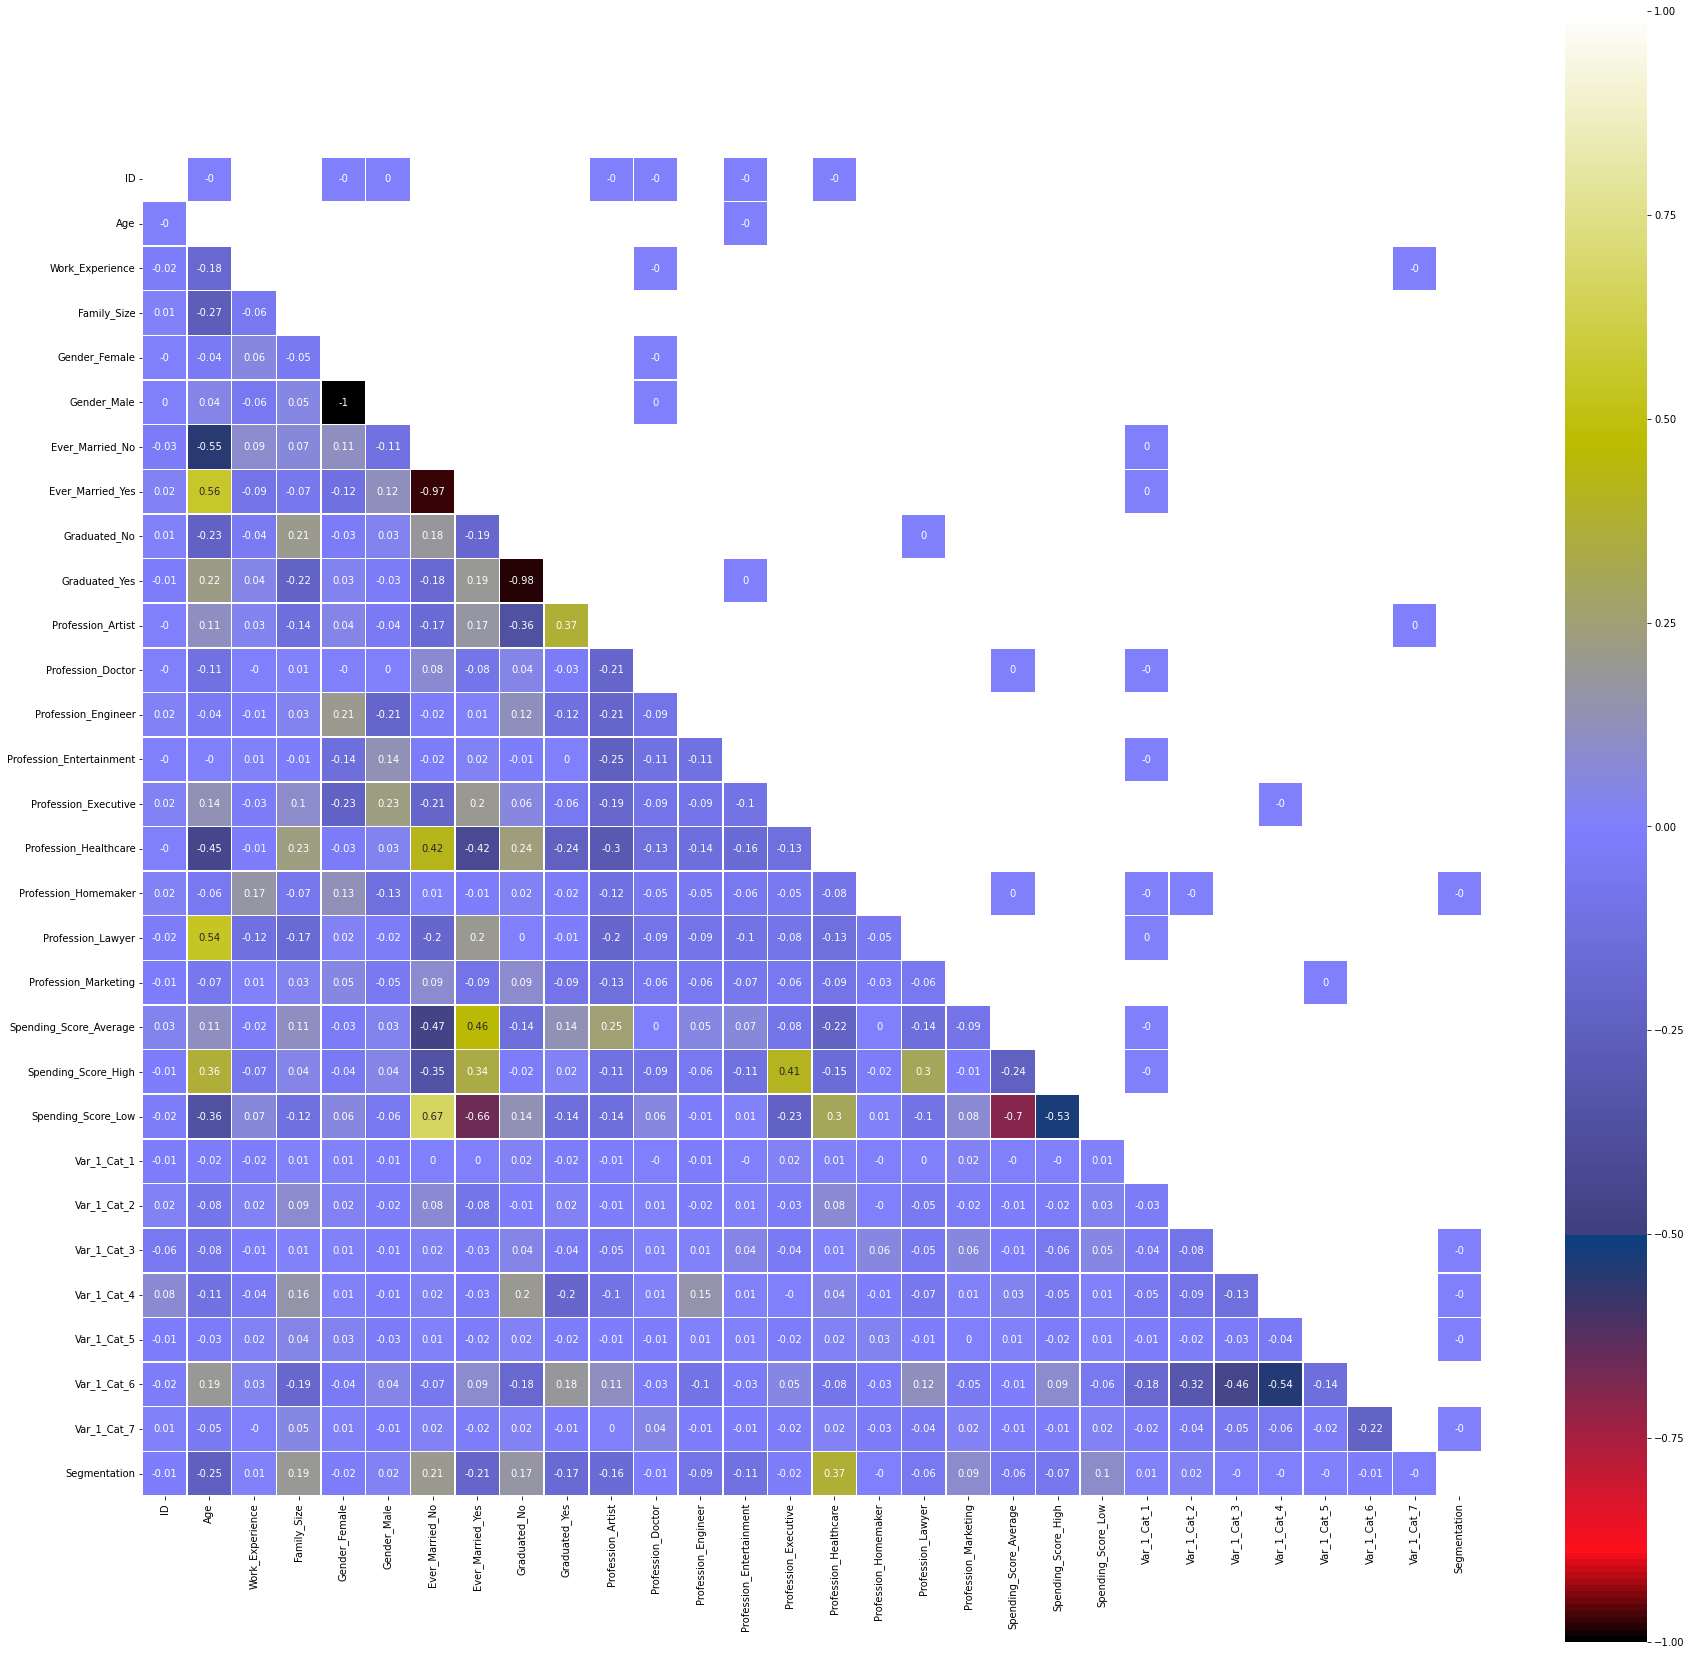

In [26]:
# correlation object
corr= train_df.corr().round(2)
# getting the Upper Triangle of the co-relation matrix
up_tri = np.triu(corr)

# PLOT
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr, vmin=-1, vmax=1,cmap= 'gist_stern',annot=True,linewidth=0.5,square=True, mask=up_tri) #,mask=matrix
plt.show();


In [27]:
# sns.pairplot(train)

---
# 2. Training
---
* Traditional ML Modeling
* Pure Torch Model
* High-level Libraries and Tabular Frameworks

## Traditional ML modeling

### Dummy Classifier

In [28]:
train_df.head()

,ID,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,-1.104402,-0.331955,-0.453388,0.780895,1.098749,-1.098749,-0.831978,0.861104,-0.772486,0.787388,...,-0.424897,0.808193,-0.1286,-0.236549,2.980539,-0.394193,-0.102421,-1.365047,-0.158415,0.0
1,-1.155079,-0.630627,-0.757754,1.444302,1.098749,-1.098749,1.201955,-1.161300,1.294522,-1.270022,...,-0.424897,0.808193,-0.1286,-0.236549,2.980539,-0.394193,-0.102421,-1.365047,-0.158415,3.0
2,-1.698708,0.325124,-0.453388,-1.209324,1.098749,-1.098749,-0.831978,0.861104,1.294522,-1.270022,...,-0.424897,0.808193,-0.1286,-0.236549,-0.335510,-0.394193,-0.102421,-1.365047,6.312535,0.0
3,-0.862916,-1.048768,1.677169,0.117489,1.098749,-1.098749,1.201955,-1.161300,1.294522,-1.270022,...,-0.424897,0.808193,-0.1286,-0.236549,-0.335510,-0.394193,-0.102421,0.732575,-0.158415,3.0
4,-1.176578,0.743265,0.155342,-1.209324,1.098749,-1.098749,1.201955,-1.161300,-0.772486,0.787388,...,-0.424897,0.808193,-0.1286,-0.236549,-0.335510,-0.394193,-0.102421,0.732575,-0.158415,0.0


In [29]:
# init model
dummy = DummyClassifier(strategy='stratified')
# fit model
dummy.fit(train_df[feature_cols], train_df[label_col])
# score
eval_score = accuracy_score(test_df[label_col], dummy.predict(test_df[feature_cols]))
# display
print('Eval ACC: {}'.format(eval_score))

Eval ACC: 0.2732342007434944


### Random Forest Classifier

In [30]:
# base model
rfc = RandomForestClassifier(n_estimators=50,max_depth=100, n_jobs=-1)

##### Parameters


In [31]:
# parameter lists
criterion_list = ['gini','entropy']
n_estimators_list = [int(x) for x in np.linspace(start = 100, stop = 200, num = 50)]
max_features_list = ['sqrt', 'log2']
max_depth_list = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split_list = [2, 5]
min_samples_leaf_list = [1, 4]
bootstrap_list = [True, False]

# grid
grid_rfc = {
            'n_estimators': n_estimators_list,
            'criterion': criterion_list,
            'max_features': max_features_list,
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'min_samples_leaf': min_samples_leaf_list,
            'bootstrap': bootstrap_list
            }

##### Random Search (RCV)


In [32]:
# searcher
rcv_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=grid_rfc, 
                                 n_iter=10, verbose=2, cv=cv, random_state=42, 
                                 n_jobs=-1)

# fit to model
# %%time
rcv_rfc.fit(train_df[feature_cols], train_df[label_col])

# best-imator
best_rfc = rcv_rfc.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


##### CV Scores

In [33]:
# get scores
mean_score_rfc = rcv_rfc.cv_results_['mean_test_score']
std_score_rfc = rcv_rfc.cv_results_['std_test_score']
params_rfc = rcv_rfc.cv_results_['params']

# frame
cv_score_df = pd.DataFrame(params_rfc)
cv_score_df['mean_score_rfc'] = mean_score_rfc
cv_score_df['std_score_rfc'] = std_score_rfc

# breakdown
breakdown_rfc = {"Index": rcv_rfc.best_index_,
"Params" : rcv_rfc.best_params_,
"Estimator" : rcv_rfc.best_estimator_,
"Score" : rcv_rfc.best_score_}

In [34]:
# display scores
for k,v in breakdown_rfc.items():
    print(f"\n{k}:")
    print(f"\n{v}")


Index:

2

Params:

{'n_estimators': 181, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}

Estimator:

RandomForestClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=181, n_jobs=-1)

Score:

0.5350180775259713


#### Test

In [35]:
rfc.fit(train_df[feature_cols],train_df[label_col])
rfc.predict(train_df[feature_cols])
# init model
rfc = best_rfc
# fit model
rfc.fit(train_df[feature_cols],train_df[label_col])
# score
rfc_score = accuracy_score(test_df[label_col], rfc.predict(test_df[feature_cols]))
# display
print('Eval ACC: {}'.format(rfc_score))

Eval ACC: 0.5408921933085502


### LGBM

In [36]:
# base model
lgbm = lgbm(n_estimators=50,max_depth=100, n_jobs=-1)

#### Parameters

In [37]:
# parameter lists
learning_rate_list = [0.02,0.03,0.04]
max_depth_list = [int(x) for x in np.linspace(10, 110, num=11)]
n_estimators_list = [int(x) for x in np.linspace(start = 100, stop = 200, num = 50)]
boosting_type_list = ['gbdt', 'rf', 'dart', 'goss']
subsample_list = [0.5,0.6,0.7,0.8]
colsample_bytree_list = [0.5,0.6,0.7,0.8,0.9]
min_data_in_leaf_list = [50,100,150]
reg_alpha_list = [0, 1, 1.5]
reg_lambda_list = [0, 1]

# grid
grid_lgbm = {
    'learning_rate': learning_rate_list,
    'max_depth': max_depth_list,
    'n_estimators': n_estimators_list,
    'boosting_type': boosting_type_list,
    'subsample_type': subsample_list,
    'colsample_bytree': colsample_bytree_list,
    'min_data_in_leaf': min_data_in_leaf_list,
    'reg_alpha': reg_alpha_list,
    'reg_lambda': reg_lambda_list,
            }

# alt
    # params = {}
    # params['learning_rate'] = 0.03
    # params['max_depth'] = 25
    # params['n_estimators'] = 3000
    # params['objective'] = 'multiclass'
    # params['boosting_type'] = 'gbdt'
    # params['subsample'] = 0.7
    # params['random_state'] = 42
    # params['colsample_bytree']=.9
    # params['min_data_in_leaf'] = 100
    # params['reg_alpha'] = 1.7
    # params['reg_lambda'] = 1.11
    # #params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

##### Random Search (RCV)


In [38]:
# searcher
rcv_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=grid_lgbm, 
                                 n_iter=10, verbose=2, cv=cv, random_state=42, 
                                 n_jobs=-1)

# fit to model
# %%time
rcv_lgbm.fit(train_df[feature_cols], train_df[label_col])

# best-imator
best_lgbm = rcv_lgbm.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


##### CV Scores

In [39]:
# get scores
mean_score_lgbm = rcv_lgbm.cv_results_['mean_test_score']
std_score_lgbm = rcv_lgbm.cv_results_['std_test_score']
params_lgbm = rcv_lgbm.cv_results_['params']

# frame
cv_score_df = pd.DataFrame(params_lgbm)
cv_score_df['mean_score_rfc'] = mean_score_lgbm
cv_score_df['std_score_rfc'] = std_score_lgbm

# breakdown
breakdown_lgbm = {"Index": rcv_lgbm.best_index_,
"Params" : rcv_lgbm.best_params_,
"Estimator" : rcv_lgbm.best_estimator_,
"Score" : rcv_lgbm.best_score_}

In [40]:
# display scores
for k,v in breakdown_lgbm.items():
    print(f"\n{k}:")
    print(f"\n{v}")


Index:

4

Params:

{'subsample_type': 0.5, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 189, 'min_data_in_leaf': 100, 'max_depth': 90, 'learning_rate': 0.04, 'colsample_bytree': 0.5, 'boosting_type': 'gbdt'}

Estimator:

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.04, max_depth=90,
               min_data_in_leaf=100, n_estimators=189, reg_alpha=1,
               reg_lambda=1, subsample_type=0.5)

Score:

0.5371873950446379


#### Test

In [41]:
# init model
lgbm = best_lgbm
# fit model
lgbm.fit(train_df[feature_cols], train_df[label_col], early_stopping_rounds=100, eval_set=[(train_df[feature_cols], train_df[label_col]), (test_df[feature_cols], test_df[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)
# score
lgbm_score = accuracy_score(test_df[label_col], lgbm.predict(test_df[feature_cols]))
# display
print('Eval ACC: {}'.format(lgbm_score))

[1]	valid_0's multi_error: 0.722033	valid_0's multi_logloss: 1.37154	valid_1's multi_error: 0.70632	valid_1's multi_logloss: 1.37063
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_error: 0.664084	valid_0's multi_logloss: 1.35596	valid_1's multi_error: 0.651177	valid_1's multi_logloss: 1.35614
[3]	valid_0's multi_error: 0.601023	valid_0's multi_logloss: 1.34252	valid_1's multi_error: 0.596035	valid_1's multi_logloss: 1.34319
[4]	valid_0's multi_error: 0.575612	valid_0's multi_logloss: 1.33129	valid_1's multi_error: 0.570012	valid_1's multi_logloss: 1.33294
[5]	valid_0's multi_error: 0.542144	valid_0's multi_logloss: 1.31895	valid_1's multi_error: 0.549566	valid_1's multi_logloss: 1.32159
[6]	valid_0's multi_error: 0.513325	valid_0's multi_logloss: 1.30721	valid_1's multi_error: 0.527881	valid_1's multi_logloss: 1.31084
[7]	valid_0's multi_error: 0.492098	valid_0's multi_logloss: 1.2963	valid_1's multi_error: 0.521685	valid_1's multi_logloss: 1.30071
[

## Pure `torch` model

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### Transform : Impute, OHE, Scale

In [44]:
# train_test split 80/20
train_df2, test_df2 = train_test_split(
    df, test_size=0.20, random_state=42
    )
train_df2.reset_index(drop=True, inplace=True)
test_df2.reset_index(drop=True, inplace=True)
# features
feature_cols = train_df2.columns.tolist()
feature_cols.remove('Segmentation')

# label

In [45]:
# train
train_df2 = transform_df(train_df2)
# test
test_df2 = transform_df(test_df2)


OHE of Subset:  'subset'

Columns Include:
   Gender
   Ever_Married
   Graduated
   Profession
   Spending_Score
   Var_1

Proceed with OHE?     y/n 

  -->  y

Let's do it!

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
...

OHE of Subset:  'subset'

Columns Include:
   Gender
   Ever_Married
   Graduated
   Profession
   Spending_Score
   Var_1

Proceed with OHE?     y/n 

  -->  y

Let's do it!

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
...


#### Update Column Groups

In [46]:
# categorical
cat_cols = ['Gender_Female', 'Gender_Male', 'Ever_Married_No',
       'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Average', 'Spending_Score_High',
       'Spending_Score_Low', 'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3',
       'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7']

# continuous
cont_cols = ['Age','Work_Experience', 'Family_Size']

# features
feature_cols = train_df2.columns.tolist()
feature_cols.remove('Segmentation')
# label
label_col = 'Segmentation'

# print(feature_cols)
# print('---')
# print(label_col)

In [47]:
len(train_df.columns)

30

#### Preparing Pipeline

##### Dataset

In [48]:
class SegDataset(Dataset):
    # Code adapted from: https://averdones.github.io/reading-tabular-data-with-pytorch-and-training-a-multilayer-perceptron/
    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X.iloc[idx].values, self.y[idx]]

    def __init__(self, x):
        super().__init__()
        self.x = x
        # Save target and predictors
        self.X = self.x[feature_cols]
        self.y = self.x[label_col]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        row = self.x.iloc[idx][1:].to_numpy(dtype="float32")
        label = self.x[0][idx]
        return torch.tensor(row, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)    

In [49]:
train_ds = SegDataset(train_df2)
valid_ds = SegDataset(test_df2)

#### Pipeline Script

In [50]:
# Workers / Batch / Epochs
N_WORKERS = cpu_count() 
BATCH_SIZE = 64 # Batch_Parameter
N_EPOCHS = 12


# Data Loaders
train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, # Batch_Mark | input_bs | Set by Batch_Parameter
    shuffle=True, 
    num_workers=N_WORKERS
)

valid_dl = DataLoader(
    valid_ds, 
    batch_size=BATCH_SIZE, # Batch_Mark | input_bs | Set by Batch_Parameter
    shuffle=False, 
    num_workers=N_WORKERS
)


# custom linear layer
def linear(in_features:int, out_features:int, dropout=0.2): 
    """
    Returns an nn.Sequential module that we want to repeat a lot.
    The module contains a linear layer, ReLU activation, BatchNorm, and dropout.
    """
    seq_mod = nn.Sequential(    
            nn.Linear(in_features=in_features, out_features=out_features), # Batch_Mark
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(p=dropout)         
            )
    return seq_mod
    raise NotImplementedError


# Config parameters for the model
class Config(AttrDict):
    def __init__(self, num_input_features=30, n_hidden_layers=2, hidden_dim=256, n_labels=1):
        self.num_input_features = num_input_features
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.n_labels = n_labels
        CUDA_LAUNCH_BLOCKING=1
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = Config()


# Model Builder
def build_model(config):
    hidden_dim = config.hidden_dim
    # model
    model = nn.Sequential(
        # 1st
        linear(in_features=config.num_input_features, out_features=hidden_dim),
        # hidden
        linear(in_features=hidden_dim, out_features=hidden_dim),
        linear(in_features=hidden_dim, out_features=hidden_dim),
        # final
        nn.Linear(in_features=hidden_dim, out_features=config.n_labels) # Batch_Mark
    )
# to device
    print('Model device: ', next(model.parameters()).device)
    if not next(model.parameters()).is_cuda & torch.cuda.is_available():
        print('Model is on CPU, but GPU is available. Putting model on GPU.')
        model = model.to(config.device)
    print('Model device: ', next(model.parameters()).device)
    return model
    raise NotImplementedError()


# Instantiate the Model
model = build_model(config)

# Loss / Opt / Metric
loss_func = nn.CrossEntropyLoss()
# opt = torch.optim.Adam(model.parameters())
opt = torch.optim.Adam(model.parameters(), amsgrad=True)
# opt = torch.optim.SGD( model.parameters(), lr=.01)
# opt = torch.optim.Adamax(lr=.02, params=model.parameters())
metric = torchmetrics.Accuracy()


# Steps: Training / Validation
def train_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    # Generate yhat
    yhat = model(x_b)
    # Calculate the loss
    loss = loss_func(yhat, y_b.long()) # Batch_Mark??
    # Calculate gradients
    loss.backward()
    # Perform your update and zero out your gradients
    opt.step()
    opt.zero_grad()
    # Update your accuracy metric
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu()) # Batch_Mark?? | softmax_mark
    # Return the loss
    return loss
    
def validation_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    # Tell torch not to calculate gradients on the validation batch
    with torch.no_grad():
        # Generate yhat
        yhat = model(x_b)
        # Calculate the loss
        loss = loss_func(yhat, y_b.long()) # Batch_Mark??
    # Update your accuracy metric
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu()) # Batch_Mark?? | softmax_mark
    # Return the loss
    return loss


Model device:  cpu
Model is on CPU, but GPU is available. Putting model on GPU.
Model device:  cuda:0


In [51]:
# Another sanity check: our model should be able to operate on a batch of data.
for x_b, y_b in train_dl:
    break

# model(x_b.to(config.device)).shape
model(x_b.to(config.device)).shape

KeyError: ignored

#### Train / Valid Model

In [ ]:
train_losses_step = []
train_losses = []
valid_losses = []
dbug_counter = 1
for epoch in range(N_EPOCHS):
    # Training loop
    model.train() # Put the model in train mode
    train_loss_epoch = 0.
    # print(dbug_counter)
    for x_b, y_b in train_dl:
        dbug_counter += 1
        # print(dbug_counter)
        loss = train_step(x_b.float(), y_b.float())
        train_loss_epoch += loss
        train_losses_step.append(loss.item())
    
    # Compute the train loss and accuracy for the epoch.
    # The epoch loss is a little bit off if our final batch
    # is a different size - we're going to ignore that for now,
    # since higher-level libraries will solve this for us.
    train_loss_epoch /= len(train_dl)
    train_losses.append(train_loss_epoch.item())
    train_acc = metric.compute()
    
    # Validation loop
    model.eval() # Put the model in eval mode (affects dropout and batch norm)
    val_loss_epoch = 0.
    for x_b, y_b in valid_dl:
        loss = validation_step(x_b.float(), y_b.float())
        val_loss_epoch += loss
    
    val_loss_epoch /= len(valid_dl)
    valid_acc = metric.compute()
    valid_losses.append(val_loss_epoch.item())

    print(f"Epoch: {epoch+1}, Train loss: {train_loss_epoch:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss_epoch} Valid Acc: {float(valid_acc):.04f}")

## High-level libraries and tabular frameworks

In [42]:
from fastai.tabular.all import *

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [44]:
TabularDataLoaders.from_df

<bound method TabularDataLoaders.from_df of <class 'fastai.tabular.data.TabularDataLoaders'>>

In [64]:
# read csv
df = pd.read_csv(csv_train)

In [65]:
cat_cols = ['Gender','Ever_Married','Graduated','Profession','Spending_Score']
cont_cols = ['Age','Work_Experience', 'Family_Size']
label_col = ['Segmentation']

In [66]:
dls = TabularDataLoaders.from_df(df, procs = [Categorify, FillMissing, Normalize], cat_names=cat_cols, cont_names=cont_cols, y_names=label_col)

In [67]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [68]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_cols,
                   cont_names = cont_cols,
                   y_names=label_col,
                   splits=splits)

In [86]:
to.valid

          ID  Gender  Ever_Married       Age  Graduated  Profession  \
3002  459937       1             1 -0.265467          2           1   
1673  461337       2             2  0.392157          2           5   
5336  464229       1             1 -1.042657          1           3   
5889  462334       2             1  0.212805          2           1   
1308  467467       2             1 -1.461145          1           6   
...      ...     ...           ...       ...        ...         ...   
5759  461549       1             2  1.468267          2           1   
4702  467116       2             2  1.767187          2           5   
1844  464089       1             2 -0.205683          2           1   
4705  460740       2             2 -0.325250          2           1   
6298  462448       2             1 -1.461145          1           6   

      Work_Experience  Spending_Score  Family_Size  Var_1  Segmentation  \
3002         1.377582               3    -1.242509  Cat_6             0 

In [76]:
dls = to.dataloaders(bs=64)

In [77]:
dls.show_batch()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Work_Experience_na,Family_Size_na,Age,Work_Experience,Family_Size,Segmentation
0,Female,No,Yes,Healthcare,Low,False,False,26.000000,-1.600446e-08,4.0,A
1,Female,No,No,Engineer,Low,False,False,38.000000,8.000000e+00,1.0,A
2,Male,Yes,Yes,Artist,Average,False,False,50.000000,-1.600446e-08,2.0,A
3,Female,Yes,No,Executive,High,False,False,37.000000,-1.600446e-08,2.0,A
4,Female,No,No,Healthcare,Low,True,False,18.999999,1.000000e+00,4.0,D
5,Female,No,Yes,Engineer,Low,False,False,39.000000,1.000000e+00,1.0,A
6,Female,Yes,Yes,Artist,High,False,False,83.999998,1.000000e+00,2.0,A
7,Male,Yes,Yes,Doctor,Average,False,False,42.000000,-1.600446e-08,2.0,C
8,Male,Yes,No,Executive,Average,False,False,52.000000,9.000000e+00,4.0,A
9,Male,Yes,Yes,Engineer,Average,False,False,45.000000,2.000000e+00,2.0,C


In [ ]:
dls.one_batch()

In [78]:
# create learner 
learn = tabular_learner(dls=dls,metrics=accuracy)

In [79]:
learn.fit_one_cycle(20, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.295647,1.209207,0.456913,00:01
1,1.216988,1.175777,0.473652,00:01
2,1.147676,1.104105,0.512089,00:01
3,1.110644,1.071763,0.524489,00:01
4,1.098932,1.080301,0.521389,00:01
5,1.085675,1.077688,0.524489,00:01
6,1.074346,1.062073,0.531928,00:01
7,1.074037,1.059149,0.531928,00:01
8,1.061921,1.063259,0.530688,00:01
9,1.059223,1.061918,0.541228,00:01


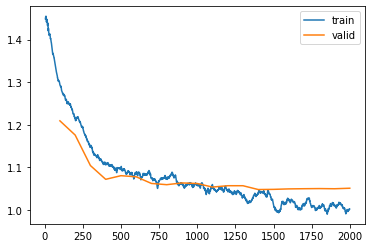

In [80]:
learn.recorder.plot_loss()

In [81]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(10, 6)
    (4): Embedding(4, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=27, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=4, bias=True)
    )
  )
)

In [83]:
learn.show_results()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Work_Experience_na,Family_Size_na,Age,Work_Experience,Family_Size,Segmentation,Segmentation_pred
0,2.0,2.0,1.0,8.0,3.0,1.0,1.0,2.424809,-0.453678,-1.242509,0.0,3.0
1,2.0,1.0,2.0,1.0,3.0,1.0,1.0,-0.504602,-0.758887,-1.242509,1.0,0.0
2,1.0,2.0,2.0,3.0,3.0,1.0,1.0,1.288915,-0.453678,-1.242509,1.0,1.0
3,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.750860,-0.453678,0.756759,2.0,2.0
4,2.0,2.0,1.0,5.0,1.0,1.0,1.0,1.468267,-0.453678,-0.576086,1.0,2.0
5,2.0,1.0,1.0,4.0,3.0,1.0,1.0,-0.624170,1.072372,-0.576086,3.0,3.0
6,2.0,2.0,2.0,1.0,2.0,2.0,1.0,-0.504602,-0.453678,-0.576086,0.0,1.0
7,2.0,2.0,2.0,5.0,2.0,1.0,1.0,0.272589,-0.758887,0.090336,2.0,2.0
8,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.049780,-0.453678,-0.576086,2.0,2.0


In [88]:
Hook(to, hook_func, is_forward=True, detach=True, cpu=False,
       gather=False)

NameError: ignored

In [82]:
# add model hook right before last lin layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

---
# 3. Testing
---
* Model Selection and Test Set Evaluation
* Notes and Findings

## Model selection and test set evaluation

In [84]:
test_df = df.copy()
test_df.drop(label_col, axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

In [85]:
learn.get_preds(dl=dl)

(tensor([[0.0094, 0.0213, 0.0335, 0.9358],
         [0.3520, 0.3690, 0.1062, 0.1728],
         [0.2733, 0.5460, 0.1398, 0.0409],
         ...,
         [0.1685, 0.0584, 0.0863, 0.6868],
         [0.0629, 0.2038, 0.2189, 0.5143],
         [0.2607, 0.3502, 0.2972, 0.0919]]), None)

## Notes and findings

What did you learn?